<a href="https://colab.research.google.com/github/gyujeong829/Fundly/blob/master/lstm_timeseries_%EA%B3%A0%EC%A0%95%EA%B9%8C%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

csv불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings


warnings.filterwarnings("ignore")
df=pd.read_csv("/content/sample_data/01.유경PSG액티브밸류증권투자신탁(주식)ClassS.csv")

In [ ]:
# 랜덤시드 고정시키기
#fix random seed for reproducibility
seed = 7
np.random.seed(seed)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#데이터셋의 5행까지 출력
df.head()

,date,price
0,2016.08.17,1000.00
1,2016.08.18,998.57
2,2016.08.19,1007.66
3,2016.08.22,1004.85
4,2016.08.23,997.55


인덱스 date로 설정해줌

In [ ]:
df.date=pd.to_datetime(df.date)
df=df.set_index("date")

In [ ]:
df.head()

,price
date,
2016-08-17,1000.00
2016-08-18,998.57
2016-08-19,1007.66
2016-08-22,1004.85
2016-08-23,997.55


400일로 바꿔줌

In [ ]:
#train, test =df[:-800], df[-800:]
from sklearn.model_selection import train_test_split
train,test = train_test_split(df, test_size=0.1, shuffle=False)

In [ ]:
scaler=MinMaxScaler()
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)

In [ ]:
n_input=30        #입력 개수
n_features=1      #독립변수의 수

generator=TimeseriesGenerator(train, train,length=n_input, batch_size=15)

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
#model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=100)


Epoch 1/100
54/54 [==============================] - 3s 58ms/step - loss: 0.0552
Epoch 2/100
54/54 [==============================] - 3s 54ms/step - loss: 0.0077
Epoch 3/100
54/54 [==============================] - 3s 54ms/step - loss: 0.0093
Epoch 4/100
54/54 [==============================] - 3s 54ms/step - loss: 0.0036
Epoch 5/100
54/54 [==============================] - 3s 55ms/step - loss: 0.0034
Epoch 6/100
54/54 [==============================] - 3s 52ms/step - loss: 0.0031
Epoch 7/100
54/54 [==============================] - 3s 55ms/step - loss: 0.0028
Epoch 8/100
54/54 [==============================] - 3s 55ms/step - loss: 0.0035
Epoch 9/100
54/54 [==============================] - 3s 52ms/step - loss: 0.0026
Epoch 10/100
54/54 [==============================] - 3s 55ms/step - loss: 0.0043
Epoch 11/100
54/54 [==============================] - 3s 52ms/step - loss: 0.0026
Epoch 12/100
54/54 [==============================] - 3s 52ms/step - loss: 0.0027
Epoch 13/100
54/54 [=====

In [ ]:
pred_list=[]
batch=train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch=np.append(batch[:,1:,:],[[pred_list[i]]], axis=1)


In [ ]:

df_predict=pd.DataFrame(scaler.inverse_transform(pred_list),index=df[-n_input:].index, columns=['Predictions'])
df_test=pd.concat([df,df_predict],axis=1)

In [ ]:
df_test.tail()

,price,Predictions
date,,
2020-05-13,1015.55,1013.998290
2020-05-14,1022.45,1017.299050
2020-05-15,1035.55,1020.640897
2020-05-18,1044.87,1024.024513
2020-05-19,1038.09,1027.450635


In [ ]:
df_mse = df['2020.04.02':'2020.05.19']

In [ ]:
print(df_mse)

              price
date               
2020-04-02   844.17
2020-04-03   859.20
2020-04-06   864.09
2020-04-07   887.87
2020-04-08   900.50
2020-04-09   908.43
2020-04-10   920.01
2020-04-13   911.66
2020-04-14   893.40
2020-04-16   908.79
2020-04-17   919.17
2020-04-20   926.11
2020-04-21   926.26
2020-04-22   927.29
2020-04-23   942.74
2020-04-24   960.04
2020-04-27   953.01
2020-04-28   962.76
2020-04-29   965.81
2020-05-04   968.57
2020-05-06   962.56
2020-05-07   990.30
2020-05-08   992.33
2020-05-11  1003.90
2020-05-12  1012.46
2020-05-13  1015.55
2020-05-14  1022.45
2020-05-15  1035.55
2020-05-18  1044.87
2020-05-19  1038.09


In [ ]:
#RMSE 구하기      RMSE는 낮을수록 정밀도가 높음
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [41.94618948]


In [ ]:
#R2 구하기          1을 최대값으로 1에 가까울수록 좋음. 음의 수가 나올 경우 학습 시 머신에 잘못이 있음
from sklearn.metrics import r2_score
r2_y_predict = r2_score(df_mse,df_predict)
print("R2: ", r2_y_predict)


R2:  0.41105949520296625


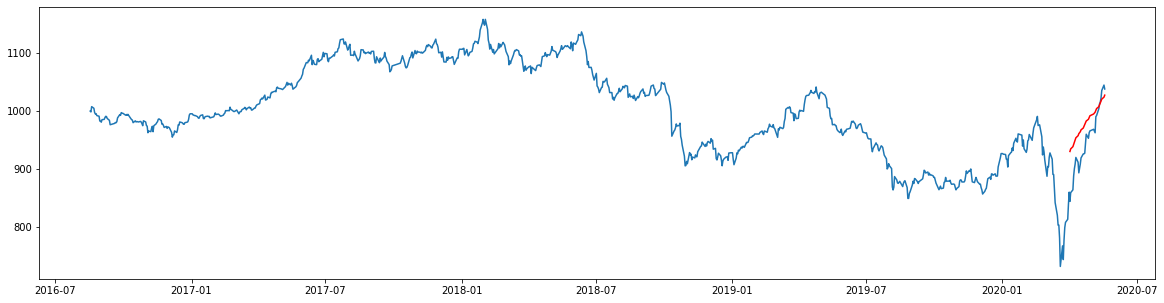

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df_test.index, df_test['price'])   #df_test.index를 df_test['price']로 줌
plt.plot(df_test.index, df_test['Predictions'],color='r')
plt.show()

In [ ]:
train=df    #train = whole data frame

scaler.fit(train)
train=scaler.transform(train)

n_input=30
n_features=1

generator=TimeseriesGenerator(train, train,length=n_input, batch_size=15)

model.fit_generator(generator, epochs=100)



pred_list=[]
batch=train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch=np.append(batch[:,1:,:],[[pred_list[i]]], axis=1)

Epoch 1/100
60/60 [==============================] - 3s 55ms/step - loss: 3.9630e-04
Epoch 2/100
60/60 [==============================] - 3s 56ms/step - loss: 3.5847e-04
Epoch 3/100
60/60 [==============================] - 3s 55ms/step - loss: 3.5448e-04
Epoch 4/100
60/60 [==============================] - 3s 54ms/step - loss: 3.4328e-04
Epoch 5/100
60/60 [==============================] - 3s 53ms/step - loss: 3.4769e-04
Epoch 6/100
60/60 [==============================] - 3s 53ms/step - loss: 3.6498e-04
Epoch 7/100
60/60 [==============================] - 3s 54ms/step - loss: 3.4798e-04
Epoch 8/100
60/60 [==============================] - 3s 54ms/step - loss: 4.0552e-04
Epoch 9/100
60/60 [==============================] - 3s 54ms/step - loss: 4.2507e-04
Epoch 10/100
60/60 [==============================] - 3s 54ms/step - loss: 3.4507e-04
Epoch 11/100
60/60 [==============================] - 3s 54ms/step - loss: 3.7653e-04
Epoch 12/100
60/60 [==============================] - 3s 56ms/s

months>days로 바꿈 30일 예측함

In [ ]:
from pandas.tseries.offsets import DateOffset
add_dates=[df.index[-1]+DateOffset(days=x)for x in range(0,31)]
future_dates=pd.DataFrame(index=add_dates[1:], columns=df.columns)

In [ ]:

future_dates.tail()

,price
2020-06-14,NaN
2020-06-15,NaN
2020-06-16,NaN
2020-06-17,NaN
2020-06-18,NaN


In [ ]:
df_predict=pd.DataFrame(scaler.inverse_transform(pred_list),
                        index=future_dates[-n_input:].index, columns=['Prediction'])

#df_proj는 기존의 df와 df_predict를 결합하여 한 눈에 보기 쉽게 하기 위함
df_proj=pd.concat([df,df_predict],axis=1)

14로 보면 12개월 예측해서밑에는 예측값, 위에는 실제값 나옴

In [ ]:
#5월 20일의 값부터 30일 동안의 값을 예측한 결과
df_proj.tail(31)

,price,Prediction
2020-05-19,1038.09,NaN
2020-05-20,NaN,1043.242156
2020-05-21,NaN,1047.128561
2020-05-22,NaN,1051.049885
2020-05-23,NaN,1055.404968
2020-05-24,NaN,1059.904960
2020-05-25,NaN,1064.452628
2020-05-26,NaN,1068.965327
2020-05-27,NaN,1073.409612
2020-05-28,NaN,1077.778215


In [ ]:
# #df2라는 데이터셋에는 5월19일부터 모델로 예측한 6월 18일까지의 기준가가 들어있음
# df2=pd.read_csv("/content/sample_data/5월19일이후.csv")
# #인덱스를 date로 설정해줌
# df2.date=pd.to_datetime(df2.date)
# df2=df2.set_index("date")
# #비어있는 값에 처리되는 NaN을 숫자 0으로 변경
# np.nan_to_num(df2, copy = False)
# df2.head()

In [ ]:
# #비교하기 편하도록 df2와 예측값을 합쳐줌
# df2_proj=pd.concat([df2,df_predict],axis=1)

In [ ]:
# #5월 20일부터 6월 18일까지의 실제 기준가와 예측값을 나란히 비교하도록 출력
# df2_proj.tail(30)

In [ ]:
# #RMSE 구하기      RMSE는 낮을수록 정밀도가 높음
# from sklearn.metrics import mean_squared_error
# def RMSE(y_test, y_predict):
#   return np.sqrt(mean_squared_error(y_test, y_predict))

# print("RMSE: ", RMSE(df2, df_predict))

In [ ]:
# #R2 구하기          1을 최대값으로 1에 가까울수록 좋음. 음의 수가 나올 경우 학습 시 머신에 잘못이 있음
# from sklearn.metrics import r2_score
# r2_y_predict = r2_score(df2,df_predict)
# print("R2: ", r2_y_predict)

No handles with labels found to put in legend.


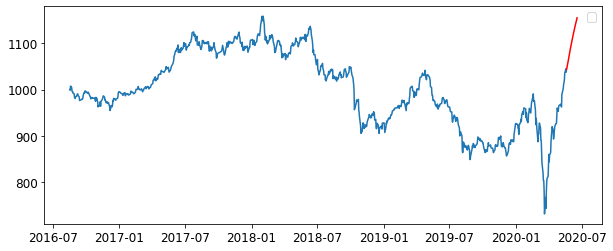

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df_proj.index, df_proj['price'])
plt.plot(df_proj.index, df_proj['Prediction'],color='r')
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

https://youtu.be/h8v9--50mdU